# Data Collection

In [2]:
import json
import glob

from pathlib import Path
from PIL import Image

import sys

parent = Path().absolute().parents[0].as_posix()

sys.path.insert(0, parent)

import numpy as np

from utils import DataExtractor

Newspapers:

- [expresso.pt](https://expresso.pt/)
- [dn.pt](https://www.dn.pt/)
- [publico.pt](https://www.publico.pt/)
- [jn.pt](https://www.jn.pt/)
- [sapo.pt](https://www.sapo.pt/)
- [cmjornal.pt](https://www.cmjornal.pt/)

Collect 200 samples for each newspaper to train a model

In [28]:
%time

de = DataExtractor(
    newspaper="publico",
    url="https://arquivo.pt/textsearch?prettyPrint=true&versionHistory=publico.pt&maxItems=2000&from=2010010100000&to=2022123100000",
    num_records_by_year=10
)

#data_to_extract = de()

CPU times: total: 0 ns
Wall time: 0 ns


## Picture Cropping

In [4]:
def crop_image(path, shape=(2000, 2000)):

    # Open the big image file
    big_image = Image.open(path)
    width, height = 2000, 2000
    num_rows = big_image.height // height

    # Loop through each row and column and crop the big image into small images
    for row in range(1):
        # Calculate the coordinates for cropping the small image
        x0 = 0
        y0 = row * height
        x1 = x0 + width
        y1 = y0 + height

        # Crop the small image from the big image
        small_image = big_image.crop((x0, y0, x1, y1))

        # Save the small image with a unique filename
        filename = path.replace("raw", "crop")
        Path(filename).parent.mkdir(exist_ok=True)
        small_image.save(filename)

In [96]:
raw_paths = []
for dir_ in glob.glob("../data/raw/*"):
    for file in glob.glob(f"{Path(dir_).as_posix()}/*"):
        raw_paths.append(file)
        
len(raw_paths)        

1477

In [97]:
raw_paths[0]

'../data/raw/cmjornal\\cmjornal-20200901070349.png'

In [99]:
for image in raw_paths:
    try:
        crop_image(image)
    except Exception as e:
        print("Error on image:", image)
        print(e)    

Error on image: ../data/raw/dn\dn-20220516112902.png
unrecognized data stream contents when reading image file


In [3]:
file = open("../annotations/project-2-at-2023-04-06-16-59-565329e3.json")
annotations = json.load(file)

In [4]:
annotations[0].keys()

dict_keys(['id', 'annotations', 'file_upload', 'drafts', 'predictions', 'data', 'meta', 'created_at', 'updated_at', 'inner_id', 'total_annotations', 'cancelled_annotations', 'total_predictions', 'comment_count', 'unresolved_comment_count', 'last_comment_updated_at', 'project', 'updated_by', 'comment_authors'])

In [4]:
annotations[0]["data"]['image']

'/data/upload/2/61ed6a99-cmjornal-20200901070349.png'

In [13]:
crop_paths = []
for dir_ in glob.glob("../data/ocr/*"):
    for file in glob.glob(f"{Path(dir_).as_posix()}/*"):
        crop_paths.append(file)
        
len(crop_paths)      

1476

### OCR data analysis

In [18]:
f = open('../data/ocr/expresso-20100409172156.json')
data = json.load(f)


In [19]:
data.keys()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])

In [20]:
import pytesseract
import cv2


def dilate(image):
    kernel = np.ones((1,1),np.uint8)
    return cv2.dilate(image, kernel, iterations = 10)

pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

custom_config = r'--oem 3 --psm 11'
img = cv2.imread('../data/crop/cmjornal/cmjornal-20200901070349.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply image thresholding
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 2)

_t = dilate(thresh)

# Apply morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

img_ocr = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT, config=custom_config)


In [21]:
from copy import deepcopy

keys = img_ocr.keys()
img_p = deepcopy(img)

n_boxes = len(img_ocr['text'])
for i in range(n_boxes):
	if int(img_ocr['conf'][i]) > 0:
		(x, y, w, h) = (img_ocr['left'][i], img_ocr['top'][i], img_ocr['width'][i], img_ocr['height'][i])
		img_p = cv2.rectangle(img_p, (x, y), (x + w, y + h), (0, 255, 0), 2)

#cv2.imshow('img', img)
#cv2.waitKey(0)

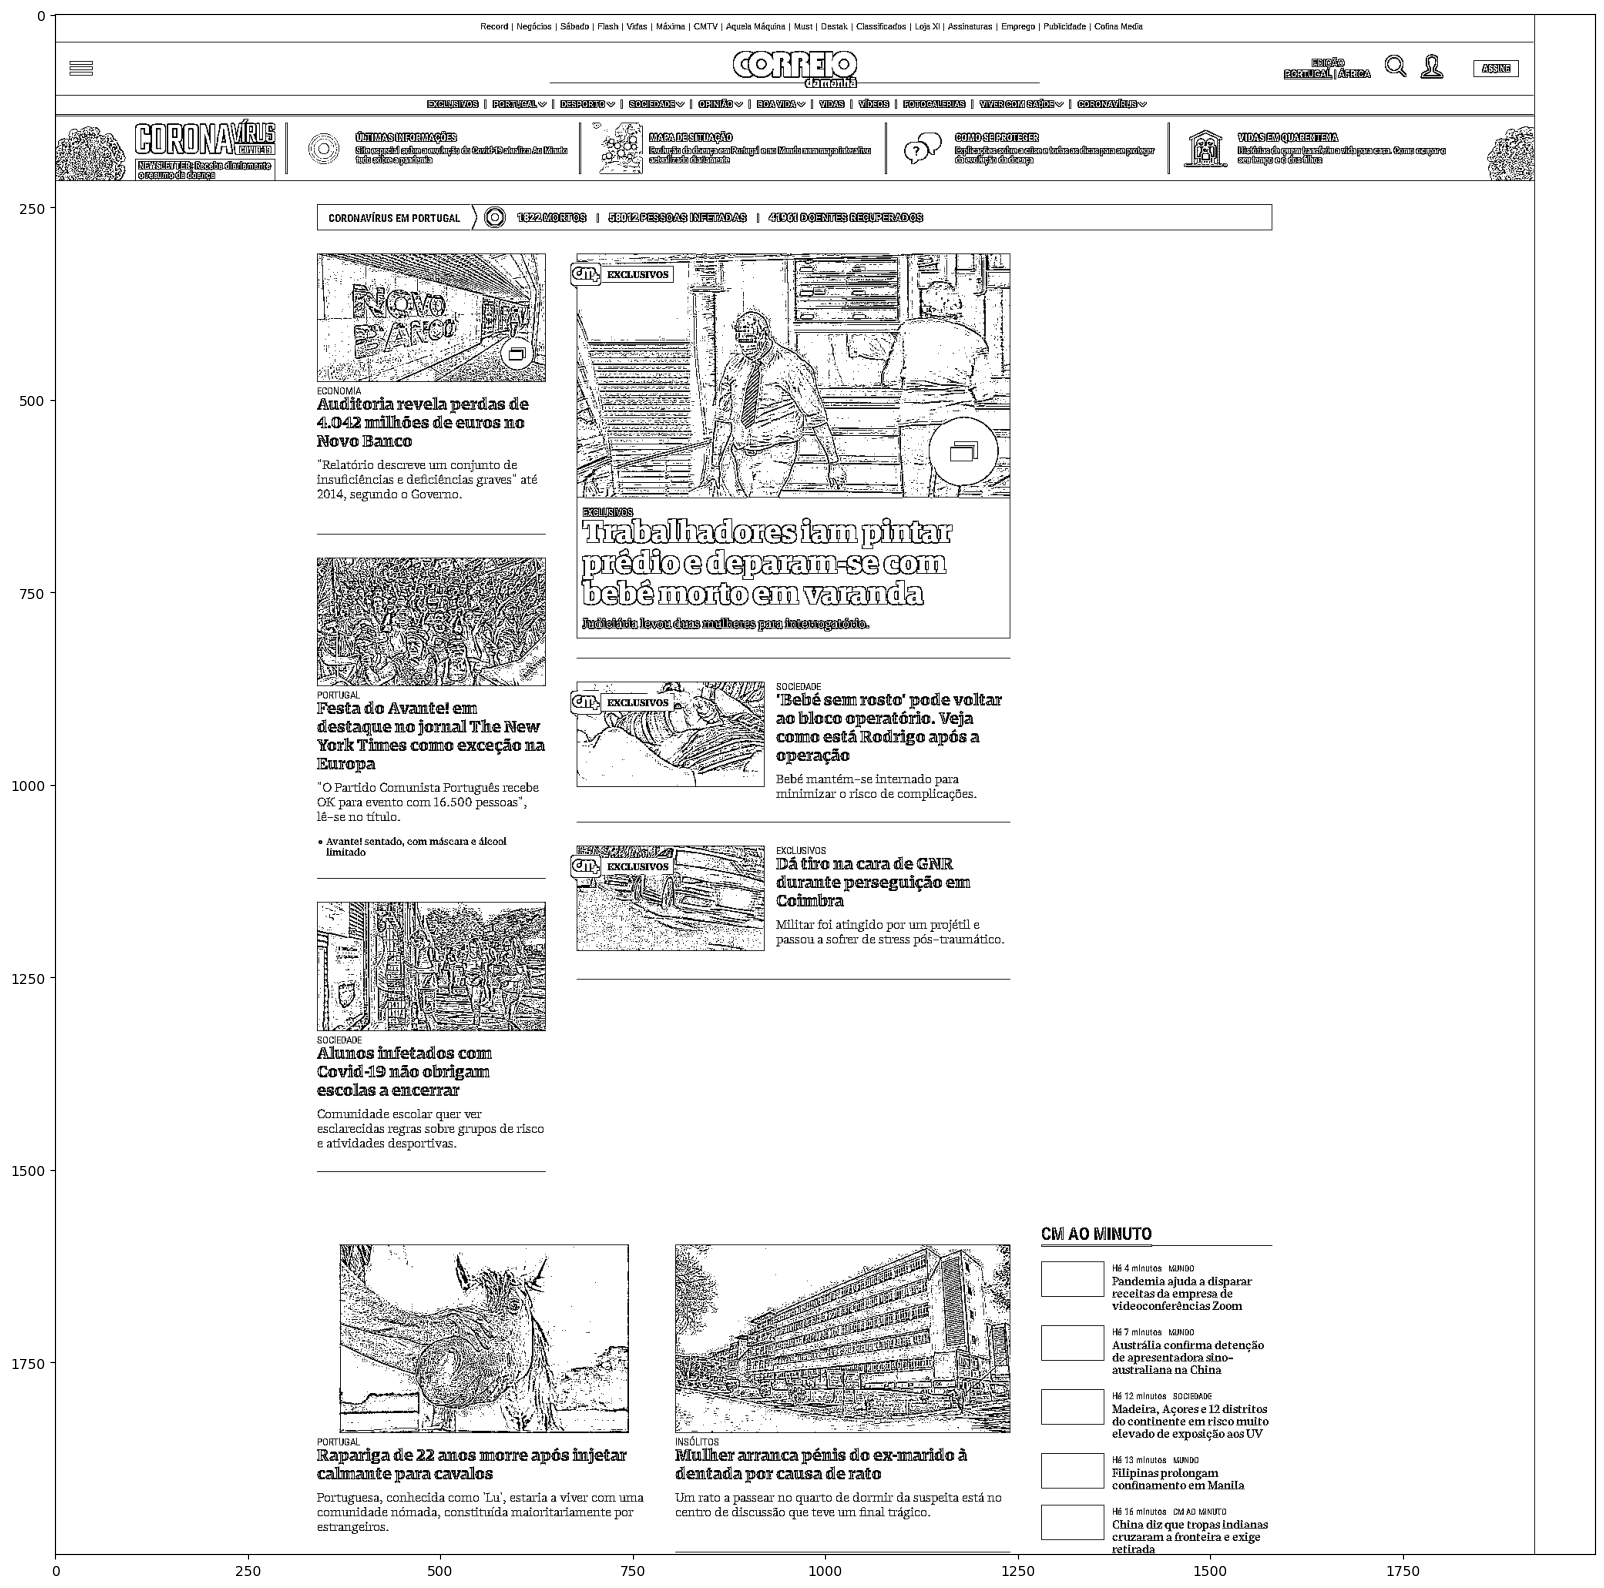

In [22]:
from matplotlib import pyplot as plt

plt.figure(figsize=(40, 20))
plt.imshow(thresh, cmap=plt.cm.gray)
plt.show()

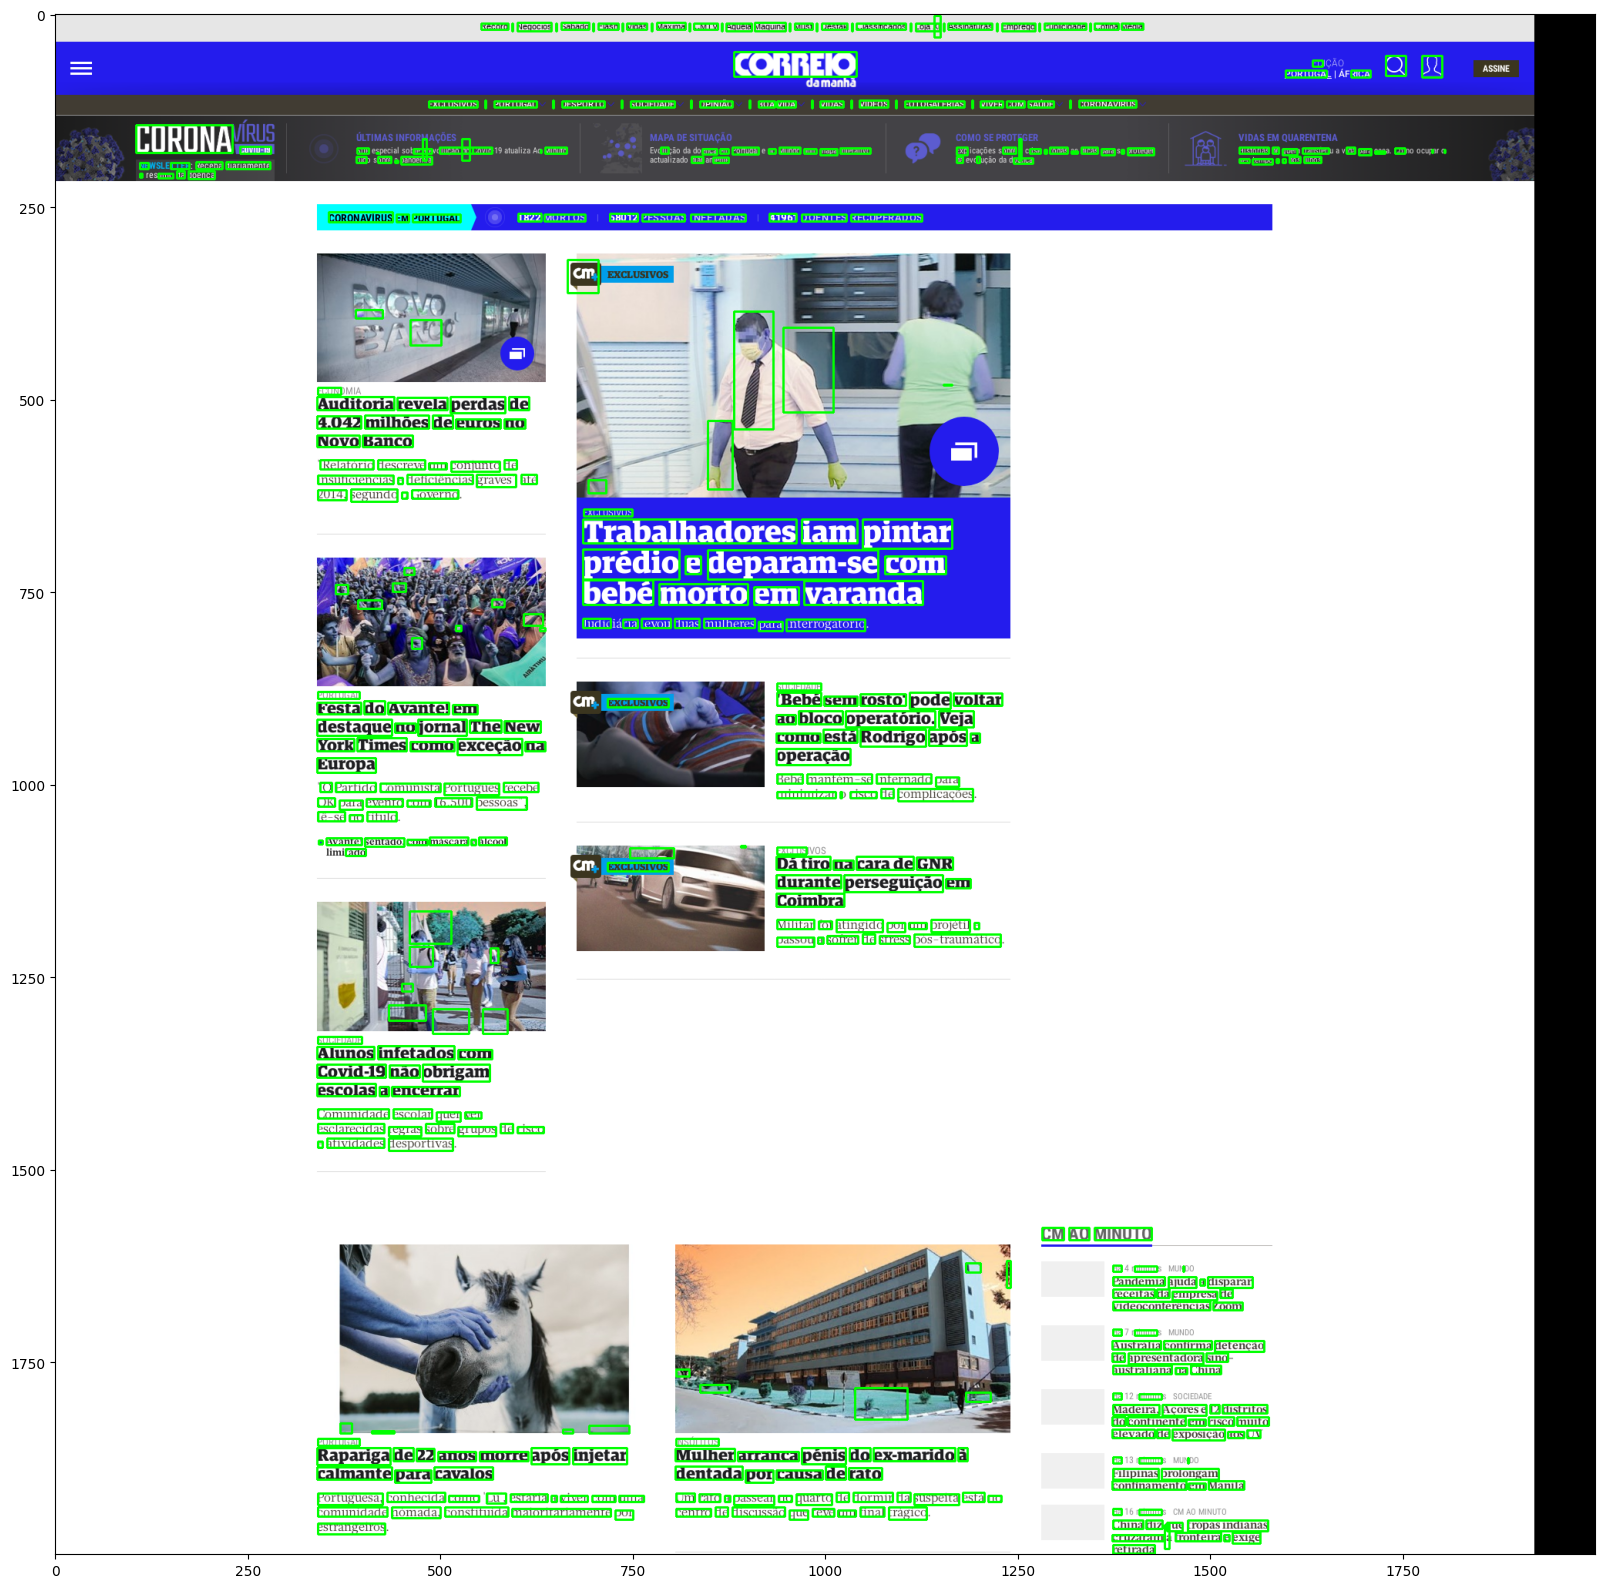

In [23]:
plt.figure(figsize=(40, 20))
plt.imshow(img_p, cmap=plt.cm.gray)
plt.show()

In [24]:
from typing import Dict
import pandas as pd

def get_text_from_ocr(annotation: Dict, ocr: pd.DataFrame) -> Dict:
    """Add text to annotation.
    
    Parameters
    ----------
    annotation : Dict
        Normalized annotation.
    ocr : pd.DataFrame
        Formatted OCR.
    
    Returns
    -------
    Dict
        Normalized annotation with corresponding bounding boxes coordinates text.
    """
    
    for bb in annotation:

        # Find all OCRs overlapping with ground truth boxes.
        ocr['_l'] = ocr['left'].apply(lambda x: max(x, bb['left']))
        ocr['_t'] = ocr['top'].apply(lambda x: max(x, bb['top']))
        ocr['_r'] = ocr['right'].apply(lambda x: min(x, bb['right']))
        ocr['_b'] = ocr['bottom'].apply(lambda x: min(x, bb['bottom']))

        overlapping_words = deepcopy(ocr).query("_l < _r and _t < _b")

        if len(overlapping_words) >= 1:

            overlapping_words['int_area'] = overlapping_words.apply(
                lambda col: (col['_r'] - col['_l']) * (col['_b'] - col['_t']), axis=1)

            overlapping_words['word_area'] = overlapping_words.apply(
                lambda col: col['width'] * col['height'], axis=1)

            overlap_ratio = 0.3    
            overlapping_words = overlapping_words.query("int_area >= @overlap_ratio * word_area")

            text = []
            words = []
            for _, region in overlapping_words.iterrows():

                text.append(region['text'])
                words.append(
                    {
                        'word': region['text'],
                        'top': region['top'],
                        'left': region['left'],
                        'right': region['right'],
                        'bottom': region['bottom'],
                        'label': bb['label'],
                    }
                )

            bb['text'] = ' '.join(text)
            bb['words'] = words

        # No overlapping between labelling boxes and ocr.
        else:

            bb['text'] = ''
            bb['words'] = []

    return annotation

In [25]:
df_ = pd.DataFrame(img_ocr)
df_['right'] = df_["left"] + df_["width"]
df_['bottom'] = df_["top"] + df_["height"]
df_


,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,right,bottom
0,1,1,0,0,0,0,0,0,2000,2000,-1,,2000,2000
1,2,1,1,0,0,0,553,11,859,11,-1,,1412,22
2,3,1,1,1,0,0,553,11,859,11,-1,,1412,22
3,4,1,1,1,1,0,553,11,859,11,-1,,1412,22
4,5,1,1,1,1,1,553,12,35,8,94,Record,588,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,5,1,162,1,1,5,1528,1972,36,14,92,exige,1564,1986
949,2,1,163,0,0,0,1373,1988,54,11,-1,,1427,1999
950,3,1,163,1,0,0,1373,1988,54,11,-1,,1427,1999
951,4,1,163,1,1,0,1373,1988,54,11,-1,,1427,1999


In [26]:
df_.query("text == 'ECONOMIA'")

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,right,bottom


In [27]:
len(annotations[0]["annotations"])

1

In [28]:
annot_ = [
    {
        'left': (val["value"]["x"] * val["original_width"]) / 100,
        'top': (val["value"]["y"] * val["original_height"]) / 100,
        'right': (val["value"]["x"] * val["original_width"]) / 100 + (val["value"]["width"] * val["original_width"]) / 100,
        'bottom': (val["value"]["y"] * val["original_height"]) / 100 + (val["value"]["height"] * val["original_height"]) / 100,
        'label':  val["value"]["rectanglelabels"][0]       
    } 
    
    for val in annotations[0]["annotations"][0]["result"]
]

annot_

[{'left': 332.60133919008257,
  'top': 477.26437519469107,
  'right': 401.84176667946787,
  'bottom': 495.8109182722049,
  'label': 'Category'},
 {'left': 336.3106478055854,
  'top': 499.52022688770774,
  'right': 620.6909749941319,
  'bottom': 563.8149095564227,
  'label': 'Title'},
 {'left': 332.60133919008257,
  'top': 572.4699629925958,
  'right': 631.8189008406403,
  'bottom': 635.5282094561431,
  'label': 'SubTitle'},
 {'left': 681.2763490473441,
  'top': 656.5476249439921,
  'right': 1142.4670535748562,
  'bottom': 767.8268834090757,
  'label': 'Title'},
 {'left': 680.0399128421762,
  'top': 780.1912454607515,
  'right': 1063.33513644413,
  'bottom': 802.4470971537683,
  'label': 'SubTitle'},
 {'left': 677.5670404318413,
  'top': 631.8189008406403,
  'right': 770.2997558194108,
  'bottom': 656.5476249439921,
  'label': 'Category'},
 {'left': 336.3106478055854,
  'top': 877.8697056689914,
  'right': 393.1867132432947,
  'bottom': 890.2340677206672,
  'label': 'Category'},
 {'left

In [29]:
_ = get_text_from_ocr(annot_, df_)

In [30]:
_

[{'left': 332.60133919008257,
  'top': 477.26437519469107,
  'right': 401.84176667946787,
  'bottom': 495.8109182722049,
  'label': 'Category',
  'text': '   ECONC',
  'words': [{'word': '',
    'top': 485,
    'left': 341,
    'right': 371,
    'bottom': 494,
    'label': 'Category'},
   {'word': '',
    'top': 485,
    'left': 341,
    'right': 371,
    'bottom': 494,
    'label': 'Category'},
   {'word': '',
    'top': 485,
    'left': 341,
    'right': 371,
    'bottom': 494,
    'label': 'Category'},
   {'word': 'ECONC',
    'top': 485,
    'left': 341,
    'right': 371,
    'bottom': 494,
    'label': 'Category'}]},
 {'left': 336.3106478055854,
  'top': 499.52022688770774,
  'right': 620.6909749941319,
  'bottom': 563.8149095564227,
  'label': 'Title',
  'text': '   Auditoria revela perdas de    4.042 milhées de euros no    Novo Banco',
  'words': [{'word': '',
    'top': 497,
    'left': 340,
    'right': 615,
    'bottom': 518,
    'label': 'Title'},
   {'word': '',
    'top': 

In [98]:
cv2.__version__

'4.7.0'

In [ ]:
glob.glob("../data/ocr/*")

In [9]:
len(annotations)

558

In [14]:
Path(annotations[0]["file_upload"]).stem

'61ed6a99-cmjornal-20200901070349'

In [45]:
annotations[1]["annotations"][0]

[{'id': 2,
  'completed_by': 1,
  'result': [],
  'was_cancelled': True,
  'ground_truth': False,
  'created_at': '2023-04-04T17:28:22.995879Z',
  'updated_at': '2023-04-04T17:28:22.995879Z',
  'lead_time': 1.444,
  'prediction': {},
  'result_count': 0,
  'unique_id': '91b7aa0b-b0b0-4dd5-8352-ac58483ca10a',
  'last_action': None,
  'task': 2,
  'project': 2,
  'updated_by': 1,
  'parent_prediction': None,
  'parent_annotation': None,
  'last_created_by': None}]

In [40]:
[val["cancelled_annotations"] for val in annotations]

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
